## Cookbook: Access and plot ipyrad stats in R

Jupyter notebooks provide a convenient interface for sharing data and functions between Python and R through use of the Python rpy2 module. In this notebook I show an example of importing data from an ipyrad JSON object and plotting stats from the assembly in R.  



### Why do this?
A large motivation of creating the JSON storage object for ipyrad Assemblies is that this object stores all of the information for an entire assembly, and thus provides a useful portable format. This way you can execute very large assemblies on a remote HPC cluster and simply import the small JSON file onto your laptop to analyze and compare its size and other stats. It is of course easiest to analyze the stats in Python since ipyrad has a built-in parser for these JSON objects. However, many users may prefer to use R for plotting, and so here we show how to easily transfer results from ipyrad to R. 


#### 2 ways to access data in the JSON file:
1. Load the data in with ipyrad and save to CSV. 
2. Load the data in with ipyrad and export to R using IPython and rpy2.

### Get an ipyrad assembly
Here we use the API to run the example RAD data set, which only takes about 1 minute on a 4-core laptop. 

In [3]:
import ipyrad as ip


In [4]:
## create a test assembly
data = ip.Assembly("test")
data.set_params(1, 'test')
data.set_params(2, 'ipsimdata/rad_example_R1_.fastq.gz')
data.set_params(3, 'ipsimdata/rad_example_barcodes.txt')

  New Assembly: test


In [7]:
%%timeit -n1
## the timeit cell magic records how long it takes to run this code once

## Assemble data set; runs steps 1-7
data.run(quiet=True, force=True)

TypeError: run() got an unexpected keyword argument 'quiet'

In [95]:
## Data can be accessed from the object's stats and stats_df attributes
data.stats

,state,reads_raw,reads_filtered,clusters_total,clusters_hidepth,hetero_est,error_est,reads_consens
1A_0,6,20093,20093,1000,1000,0.001965,0.000755,1000
1B_0,6,19938,19938,1000,1000,0.001865,0.000751,1000
1C_0,6,20054,20054,1000,1000,0.001969,0.000744,1000
1D_0,6,20066,20066,1000,1000,0.001934,0.000766,1000
2E_0,6,19838,19838,1000,1000,0.002077,0.000751,1000
2F_0,6,20033,20033,1000,1000,0.001887,0.000739,1000
2G_0,6,20145,20145,1000,1000,0.001898,0.000765,1000
2H_0,6,20158,20158,1000,1000,0.001932,0.000736,1000
3I_0,6,20010,20010,1000,1000,0.001866,0.000764,1000
3J_0,6,19977,19977,1000,1000,0.002291,0.000778,1000


In [36]:
data.stats_dfs.s7_loci

,locus_coverage,sum_coverage
1,NaN,0
2,NaN,0
3,NaN,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0
10,0,0


### Load R-language extension
This requires that you have the Python module `rpy2` installed. If you do not, it can be installed in anaconda with: `conda install rpy2`

In [10]:
## now we tell IPython to load the rpy2 extension
load_ext rpy2.ipython

### Transfer python object to R
There are a few odd tricks to doing using this module. One being that you shouldn't try to pass it named objects with '.' in their names. R won't like that. So simply rename these objects before passing them. Below I rename the stats data frame and then use the '-i' flag in R to import it into R namespace. The "%R" at the beginning of the line tells IPyhton to execute just that line as R code. 

In [25]:
## rename data.stats as statsDF
statsDF = data.stats

## import statsDF into R
%R -i statsDF

### Now R knows about statsDF
we can access it just like a normal R DataFrame, and even create plots. Using the cell header %%R everything in the cell will execute as R code. 

In [26]:
%%R 
print(statsDF)


     state reads_raw reads_filtered clusters_total clusters_hidepth  hetero_est
1A_0     6     20093          20093           1000             1000 0.001965305
1B_0     6     19938          19938           1000             1000 0.001865104
1C_0     6     20054          20054           1000             1000 0.001968599
1D_0     6     20066          20066           1000             1000 0.001934149
2E_0     6     19838          19838           1000             1000 0.002077262
2F_0     6     20033          20033           1000             1000 0.001886744
2G_0     6     20145          20145           1000             1000 0.001898473
2H_0     6     20158          20158           1000             1000 0.001931724
3I_0     6     20010          20010           1000             1000 0.001865512
3J_0     6     19977          19977           1000             1000 0.002291394
3K_0     6     20061          20061           1000             1000 0.001808438
3L_0     6     19975          19975     

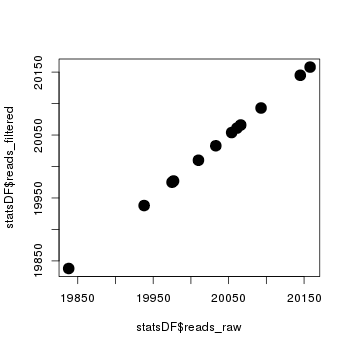

In [92]:
%%R -w 350 -h 350
## the dimensions above tell IPython how big to make the embedded figure
## alternatively you can adjust the size when you save the figure using
## normal methods in R.

plot(statsDF$reads_raw, 
     statsDF$reads_filtered, 
     pch=20, cex=3)


In [38]:
### Other stats are available too
### store names and import into R
s5 = data.stats_dfs.s5
s7L = data.stats_dfs.s7_loci
s7S = data.stats_dfs.s7_snps
s7N = data.stats_dfs.s7_samples

## no spaces allowed between names
%R -i s5,s7L,s7S,s7N

### Plot coverage among samples 
Kinda boring in this example...

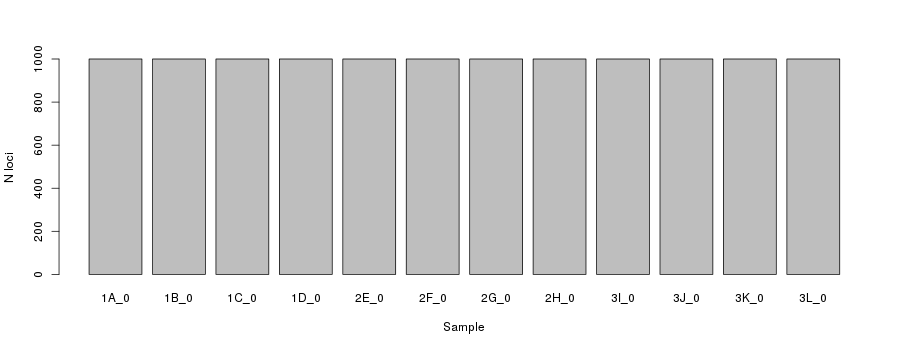

In [93]:
%%R -w 900 -h 350
## 
barplot(s7N$sample_coverage, 
        col='grey', names=rownames(s7N),
        ylab="N loci",
        xlab="Sample")

### Plot the distribution of SNPs among loci

   var sum_var pis sum_pis
0    9       0 316       0
1   44      44 368     368
2  117     278 205     778
3  173     797  84    1030
4  183    1529  19    1106
5  165    2354   5    1131
6  143    3212   2    1143
7   76    3744   1    1150
8   45    4104   0    1150
9   25    4329   0    1150
10  14    4469   0    1150
11   5    4524   0    1150
12   0    4524   0    1150
13   1    4537   0    1150


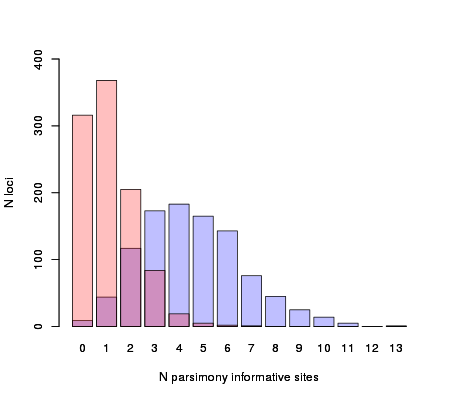

In [85]:
%%R -w 450 -h 400
print(s7S)

barplot(s7S$var, 
        col=rgb(0,0,1,1/4), 
        names=rownames(s7S),
        ylab="N loci", ylim=c(0, 400),
        xlab="N parsimony informative sites")

barplot(s7S$pis, 
        col=rgb(1,0,0,1/4), 
        names=rownames(s7S),
        ylab="N loci", ylim=c(0, 400),
        xlab="N parsimony informative sites", 
        add=TRUE)

### Future 
You can of course make much more complex figures with the data for your Assembly. See also the R package RADami which has some functions for analysis and plotting using the .loci output file from ipyrad. 